In [1]:
# there no change change in the first several cells from last lecture

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# ok biolerplate done, now we get to the action:

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv # [32, 27] * [32, 1]。这里有一个 implicit broadcasting；后面那个column tensor会被replicate 27次
# probs_commutative =  counts_sum_inv * counts
# assert torch.all(probs == probs_commutative) == True
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3443, grad_fn=<NegBackward0>)

在PyTorch中，`logprobs[range(n), Yb]` 这种索引方式利用了高级索引（Advanced Indexing）的特性。高级索引允许你使用多个索引数组来同时索引多个维度，从而实现更复杂的索引操作。

具体来说，`logprobs[range(n), Yb]` 的工作原理如下：

1. **`range(n)`**：
   - 生成一个从 `0` 到 `n-1` 的整数序列。这实际上是一个长度为 `n` 的数组，表示要选择的行索引。
   - 假设 `n = 32`，那么 `range(n)` 就是 `[0, 1, 2, ..., 31]`。

2. **`Yb`**：
   - 这是一个长度为 `n` 的张量，表示要选择的列索引。
   - 例如，`Yb` 是 `tensor([8, 14, 15, ..., 18])`。

3. **高级索引**：
   - 当你使用 `logprobs[range(n), Yb]` 时，PyTorch 会将 `range(n)` 和 `Yb` 视为两个索引数组。
   - `range(n)` 指定了要选择的行索引，`Yb` 指定了要选择的列索引。
   - PyTorch 会逐元素地将这两个数组组合起来进行索引。例如，第一个元素是 `(0, 8)`，第二个元素是 `(1, 14)`，依此类推。

因此，`logprobs[range(n), Yb]` 会返回一个长度为 `n` 的张量，其中每个元素是 `logprobs` 中对应位置的值。具体来说，它会返回以下值：
- `logprobs[0, 8]`
- `logprobs[1, 14]`
- `logprobs[2, 15]`
- ...
- `logprobs[31, 18]`

这就是如何通过高级索引来同时索引行和列的方式。高级索引在处理多维数组时非常强大，可以用来实现复杂的索引和切片操作。

In [10]:
print(f'{logprobs.shape=}')
print(f'{probs.shape=}')
print(f'{counts.shape=}')
print(f'{counts_sum.shape=}')
print(f'{counts_sum_inv.shape=}')
print(f'{logits.shape=}')
print(f'{norm_logits.shape=}')
print(f'{logit_maxes.shape=}')
print(f'{h.shape=}')
print(f'{W2.shape=}')
print(f'{b2.shape=}')

logprobs.shape=torch.Size([32, 27])
probs.shape=torch.Size([32, 27])
counts.shape=torch.Size([32, 27])
counts_sum.shape=torch.Size([32, 1])
counts_sum_inv.shape=torch.Size([32, 1])
logits.shape=torch.Size([32, 27])
norm_logits.shape=torch.Size([32, 27])
logit_maxes.shape=torch.Size([32, 1])
h.shape=torch.Size([32, 64])
W2.shape=torch.Size([64, 27])
b2.shape=torch.Size([27])


In [11]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

#FORWARD PASS# loss = -logprobs[range(n), Yb].mean()
# 案例：loss = -1/3a + -1/3b + -1/3c
# 推广：dloss/da = -1/n
dlogprobs =  torch.zeros_like(logprobs) # logprobs.shape = [32,27]. 
dlogprobs[range(n), Yb] = -1.0/n # logprobs 其中 32 个 element 对 loss 有影响，剩余的无影响，即 grad = 0

#FORWARD PASS# logprobs = probs.log()
dprobs = (1.0 / probs) * dlogprobs # probs [32, 27]

#FORWARD PASS# probs = counts * counts_sum_inv; 这里其实包含了两个operation: 1. replicate column tensor 2. element-wise multiplication
# counts.shape = [32, 27]; counts_sum_inv.shape = [32, 1]
# 为了element-wise乘法，torch会做implicit broadcasing，把 column vector 从[32, 1] -> [32, 27]
# c = a * b, but with tensors: 注意这里不是矩阵的乘法，和 @ 操作区分，输出的 C.shape = 3,3
# 第一个 operation 是 replicateion，第二个 operation 是 multiplication
# a[3x3] * b[3,1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]
# torch.sum(dim): the dimension or dimensions to reduce. If None, all dimensions are reduced.
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
#FORWARD PASS# probs = counts * counts_sum_inv;
dcounts = counts_sum_inv * dprobs # [32, 1] * [32, 27]; 这里会有implicit broadcast

#FORWARD PASS# counts_sum_inv = counts_sum**-1
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

#FORWARD PASS# counts_sum = counts.sum(1, keepdim=True)
# a11 a12 a13 ---> b1 (= a11 + a12 + a13)
# a21 a22 a23 ---> b2 (= a21 + a22 + a23)
# a31 a32 a33 ---> b3 (= a31 + a32 + a33)
dcounts += torch.ones_like(counts) * dcounts_sum # 让 implict broadcast 来做 multiplication，即 grad 的 router

#FORWARD PASS# counts = norm_logits.exp()
dnorm_logits = counts * dcounts # counts = norm_logits.exp(); X.exp() 的 derivative 就是 X.exp()

#FORWARD PASS# norm_logis = logits - logit_maxes
# dlogit_maxes 几乎都是0，因为这步是为了 numerical stability，不影响 loss 的结果
# c11 c12 c13 = a11 a12 a13     b1
# c21 c22 c23 = a21 a22 a23    -b2
# c31 c32 c33 = b31 a32 a33     b3
# so e.g., c32 = a32 - b3
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

#FORWARD PASS# logit_maxes = logits.max(1, keepdim=True).values
# plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

#FORWARD PASS# logits = h @ W2 + b2
# h.shape = [32, 64]
# logits.shape = [32, 27]
# W2.shape = [64, 27]
# b2.shape = [27]
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

In [12]:
print(f'{hpreact.shape=}')
print(f'{bngain.shape=}')
print(f'{bnraw.shape=}')
print(f'{bnbias.shape=}')
print(f'{bndiff.shape=}')
print(f'{bnvar.shape=}')
print(f'{bnvar_inv.shape=}')
print(f'{bndiff2.shape=}')
print(f'{hprebn.shape=}')
print(f'{bnmeani.shape=}')

hpreact.shape=torch.Size([32, 64])
bngain.shape=torch.Size([1, 64])
bnraw.shape=torch.Size([32, 64])
bnbias.shape=torch.Size([1, 64])
bndiff.shape=torch.Size([32, 64])
bnvar.shape=torch.Size([1, 64])
bnvar_inv.shape=torch.Size([1, 64])
bndiff2.shape=torch.Size([32, 64])
hprebn.shape=torch.Size([32, 64])
bnmeani.shape=torch.Size([1, 64])


In [13]:
#FORWARD PASS# h = torch.tanh(hpreact)
dhpreact = (1.0 - h**2) * dh

#FORWARD PASS# hpreact = bngain * bnraw + bnbias
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw =  bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

#FORWARD PASS# bnraw = bndiff * bnvar_inv
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

#FORWARD PASS# bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

#FORWARD PASS# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# a11 a12
# a21 a22
# --->
# b1 b2, where:
# b1 = 1/(n-1)*(a11 + a21)
# b2 = 1/(n-1)*(a12 + a22)
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar

#FORWARD PASS# bndiff2 = bndiff**2
dbndiff += 2 * bndiff * dbndiff2

#FORWARD PASS# bndiff = hprebn - bnmeani
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0) # dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)
#FORWARD PASS# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

In [14]:
print(f'{hprebn.shape=}')
print(f'{embcat.shape=}')
print(f'{W1.shape=}')
print(f'{b1.shape=}')

hprebn.shape=torch.Size([32, 64])
embcat.shape=torch.Size([32, 30])
W1.shape=torch.Size([30, 64])
b1.shape=torch.Size([64])


In [15]:
#FORWARD PASS# hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

In [16]:
print(f'{embcat.shape=}')
print(f'{emb.shape=}')

embcat.shape=torch.Size([32, 30])
emb.shape=torch.Size([32, 3, 10])


In [17]:
#FORWARD PASS# embcat = emb.view(emb.shape[0], -1) 
demb = dembcat.view(emb.shape)

In [18]:
print(f'{emb.shape=}')
print(f'{C.shape=}')
print(f'{Xb.shape=}')

emb.shape=torch.Size([32, 3, 10])
C.shape=torch.Size([27, 10])
Xb.shape=torch.Size([32, 3])


In [19]:
#FORWARD PASS# emb = C[Xb]
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [20]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.344327926635742 diff: -4.76837158203125e-07


In [21]:
print(f'{logits.shape=}')

logits.shape=torch.Size([32, 27])


In [22]:
# backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [23]:
F.softmax(logits, 1).shape

torch.Size([32, 27])

In [24]:
F.softmax(logits, 1)[0]

tensor([0.0759, 0.0905, 0.0186, 0.0503, 0.0193, 0.0838, 0.0243, 0.0347, 0.0181,
        0.0317, 0.0354, 0.0364, 0.0341, 0.0288, 0.0331, 0.0138, 0.0095, 0.0187,
        0.0158, 0.0542, 0.0489, 0.0201, 0.0235, 0.0750, 0.0601, 0.0252, 0.0201],
       grad_fn=<SelectBackward0>)

In [25]:
dlogits[0] * n

tensor([ 0.0759,  0.0905,  0.0186,  0.0503,  0.0193,  0.0838,  0.0243,  0.0347,
        -0.9819,  0.0317,  0.0354,  0.0364,  0.0341,  0.0288,  0.0331,  0.0138,
         0.0095,  0.0187,  0.0158,  0.0542,  0.0489,  0.0201,  0.0235,  0.0750,
         0.0601,  0.0252,  0.0201], grad_fn=<MulBackward0>)

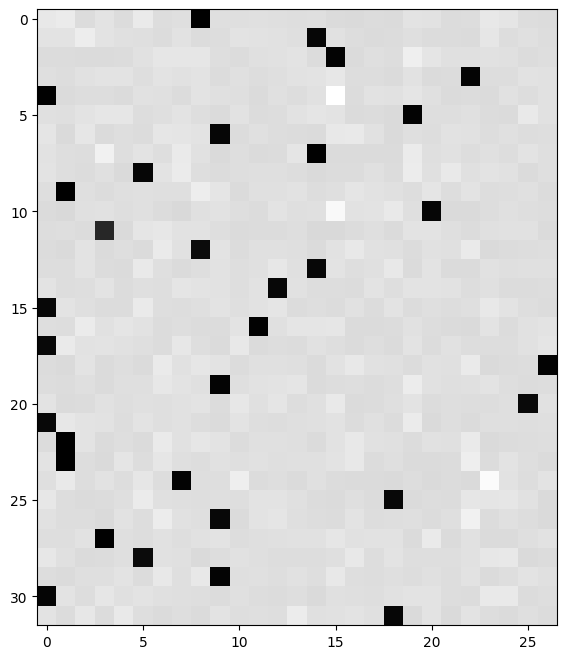

In [26]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [27]:
dlogits[0].sum()

tensor(3.7253e-09, grad_fn=<SumBackward0>)

In [28]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [29]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [31]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [37]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i >= 100: # TODO: delete early breaking when you're ready to train the full net
      break

12297
      0/ 200000: 3.8255


In [38]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [ ]:
1h51min50ss